In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
from typing import Tuple, Callable

from wishart_clustering import wishart_clustering

In [2]:
np.random.seed(100)

In [3]:
def flatten(clusters: list[np.ndarray], shuffle=False) -> np.ndarray:
    result = []
    for cluster in clusters:
        result += list(cluster)
    result = np.array(result)
    np.random.shuffle(result)
    return result

def generate_k_dim_point(k: int, r: float):
    point = np.random.uniform(-r, r, k)
    while np.linalg.norm(point) > r:
        point = np.random.uniform(-r, r, k)
    return point

def generate_clusters(k: int, cluster_number: int, cluster_size: Tuple[int, int], cluster_scale: Tuple[float, float], radius_func:Callable=lambda x: x**2, seed:int=0, draw:bool=False) ->list[np.ndarray]:
    if seed != 0:
        np.random.seed(seed)
    clusters = [[] for _ in range(cluster_number)]
    for i in range(cluster_number):
        current_size = np.random.randint(*cluster_size)
        current_scale = np.random.uniform(*cluster_scale)
        center = np.random.uniform(0, 1, k)

        clusters[i] = np.zeros((current_size, k))
        r = radius_func(np.random.uniform(0, current_scale, current_size))
        for j in range(current_size):
            clusters[i][j] = generate_k_dim_point(k, r[j])
        clusters[i] += center

    if draw:
        for i, cluster in enumerate(clusters):
            plt.scatter(cluster[:, 0], cluster[:, 1], s=2, color=np.random.rand(1, 3), label=f"Cluster {i}")
        plt.title(f"Clusters: number_of_clusters={len(clusters)} ")
        plt.grid()
        if cluster_number <= 20:
            plt.legend(bbox_to_anchor=(1, 1))
        plt.show()
    return clusters

In [4]:
def clasterify(k: int, data: np.ndarray, r: int, mu: float, draw:bool=False, draw_noise=True) -> list[np.ndarray]:
    wishart_clusters = wishart_clustering(data, k, r, mu)
    clusters_to_draw = wishart_clusters
    if draw:
        if not draw_noise:
            clusters_to_draw = clusters_to_draw[1:]
        for i, cluster in enumerate(clusters_to_draw):
            plt.scatter(cluster[:, 0], cluster[:, 1], s=2, color=np.random.rand(1, 3), label=f"Cluster {i}")
        plt.title(f"Wishart clustering: number_of_clusters={len(clusters_to_draw)}")
        plt.grid()
        if len(clusters_to_draw) <= 20:
            plt.legend(bbox_to_anchor=(1, 1))
        plt.show()
    return wishart_clusters

In [5]:
def RMSSTD(clusters: list[np.ndarray]) -> float:
    k = clusters[0].shape[1]
    return np.sqrt(sum(np.sum((clst - np.average(clst, axis=0)) ** 2) for clst in clusters) / (k * sum(clst.shape[0] - 1 for clst in clusters)))

def RS(clusters: list[np.ndarray]) -> float:
    all_dots = flatten(clusters)
    return 1 - sum(np.sum((clst - np.average(clst, axis=0)) ** 2) for clst in clusters) / np.sum((all_dots - np.average(all_dots, axis=0)) ** 2)

def ModifiedHubert(clusters: list[np.ndarray]) -> float:
    all_dots = []
    inds = []
    centers = [0] * len(clusters)
    for i, clst in enumerate(clusters):
        all_dots += list(clst)
        inds += [i] * len(clst)
        centers[i] = np.average(clst, axis=0)
    result = 0
    for i in range(len(all_dots)):
        for j in range(i + 1, len(all_dots)):
            result += np.linalg.norm(all_dots[i] - all_dots[j]) * np.linalg.norm(centers[inds[i]] - centers[inds[j]])
    return result * 2 / len(all_dots) / (len(all_dots) - 1)

def CH(clusters: list[np.ndarray]) -> float:
    all_center = sum(np.sum(clst, axis=0) for clst in clusters) / sum(clst.shape[0] for clst in clusters)
    numer = sum(clst.shape[0] * np.linalg.norm(np.average(clst, axis=0) - all_center) ** 2 for clst in clusters) / (len(clusters) - 1)
    denom = 0
    for clst in clusters:
        clst_center = np.average(clst, axis=0)
        denom += sum(np.linalg.norm(x - clst_center, axis=0) ** 2 for x in clst)
    denom /= sum(clst.shape[0] for clst in clusters) - len(clusters)
    return numer / denom

def I(clusters: list[np.ndarray]) -> float:
    k = clusters[0].shape[1]
    all_center = sum(np.sum(clst, axis=0) for clst in clusters) / sum(clst.shape[0] for clst in clusters)
    numer = 0
    denom = 0
    centers = np.zeros((len(clusters), k))
    for i, clst in enumerate(clusters):
        centers[i] = np.average(clst, axis=0)
        numer += np.sum(np.linalg.norm(clst - all_center[np.newaxis, :], axis=1))
        denom += np.sum(np.linalg.norm(clst - centers[i][np.newaxis, :], axis=1))
    numer *= np.max(np.linalg.norm(centers[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2))
    return (numer / denom / len(clusters)) ** k

def D(clusters: list[np.ndarray]) -> float:
    numer = 1e18
    denom = 0
    for i, clst in enumerate(clusters):
        denom = max(denom, np.max(np.linalg.norm(clst[:, np.newaxis, :] - clst[np.newaxis, :, :], axis=2)))
        for j, clst2 in enumerate(clusters):
            if i != j:
                numer = min(numer, np.min(np.linalg.norm(clst[:, np.newaxis, :] - clst2[np.newaxis, :, :], axis=2)))
    return numer / denom

def S(clusters: list[np.ndarray]) -> float:
    result = 0
    for clst1_ind, clst1 in enumerate(clusters):
        current_sum = 0
        for i, x in enumerate(clst1):
            a = (np.sum(np.linalg.norm(clst1[:i] - x[np.newaxis, :], axis=1)) + np.sum(np.linalg.norm(clst1[i + 1:] - x[np.newaxis, :], axis=1))) / (clst1.shape[0] - 1)
            b = 1e18
            for clst2_ind, clst2 in enumerate(clusters):
                if clst1_ind != clst2_ind:
                    b = min(b, np.sum(np.linalg.norm(clst2 - x[np.newaxis, :], axis=1)) / clst2.shape[0])
            current_sum += (b - a) / max(b, a)
        result += current_sum / clst1.shape[0]
    return result / len(clusters)

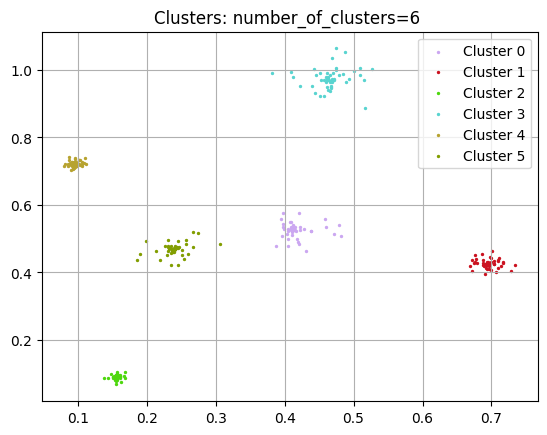

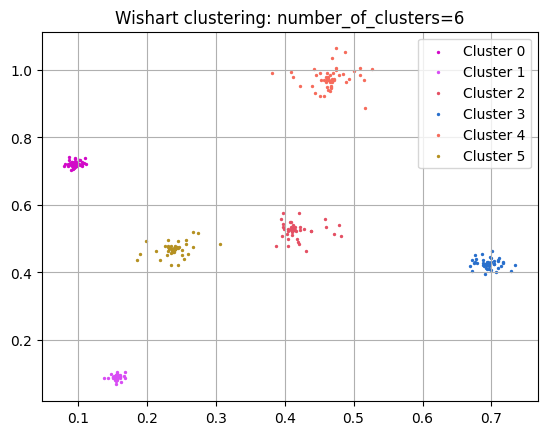

In [6]:
data = flatten(generate_clusters(2, 6, (50, 101), (0.1, 0.4), radius_func=lambda x: x**2, seed=100, draw=True), shuffle=True)
__ = clasterify(2, data, 10, 0.2, draw=True)

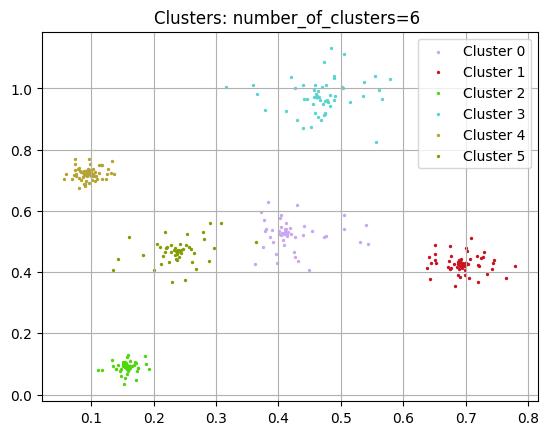

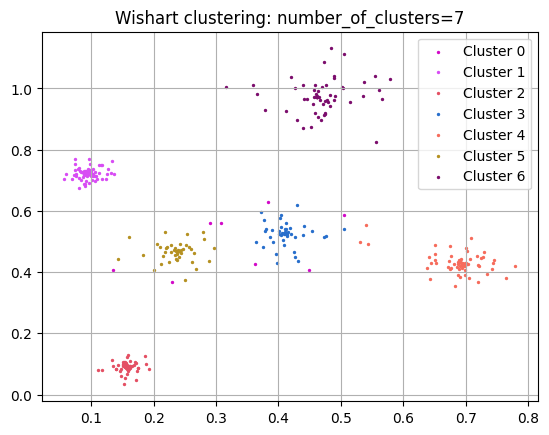

In [7]:
data = flatten(generate_clusters(2, 6, (50, 101), (0.1, 0.4), radius_func=lambda x: x**1.5, seed=100, draw=True), shuffle=True)
__ = clasterify(2, data, 15, 0.2, draw=True)

In [8]:
#data = flatten(generate_clusters(2, 20, (70, 101), (0.3, 0.4), radius_func=lambda x: x**1.8, seed=100, draw=True), shuffle=True)
#A = clasterify(2, data, 60, 0.3, draw=True)

In [9]:
initial_clustering = generate_clusters(4, 8, (40, 51), (0.1, 0.5), radius_func=lambda x: x, seed=101)
wishart_results = wishart_clustering(flatten(initial_clustering, shuffle=True), 4, 20, 0.1)

print(len(wishart_results))

8


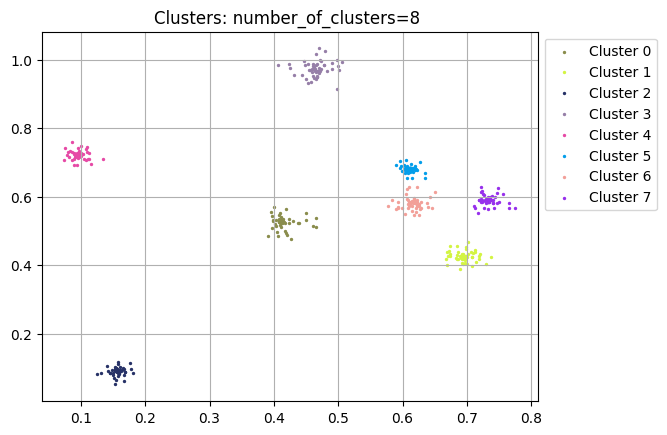

In [10]:
K = 2
initial_clustering = generate_clusters(K, 8, (50, 71), (0.1, 0.2), radius_func=lambda x: x**1.5, seed=100, draw=True)
data = flatten(initial_clustering, shuffle=True)

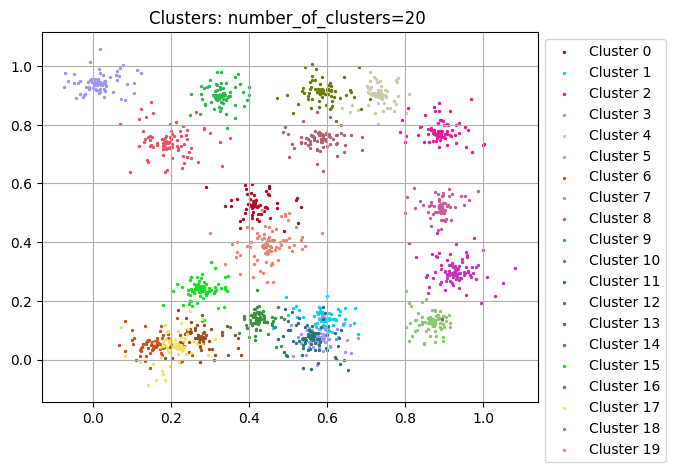

In [11]:
K = 2
initial_clustering = generate_clusters(K, 20, (70, 101), (0.3, 0.4), radius_func=lambda x: x**1.8, seed=100, draw=True)
data = flatten(initial_clustering, shuffle=True)

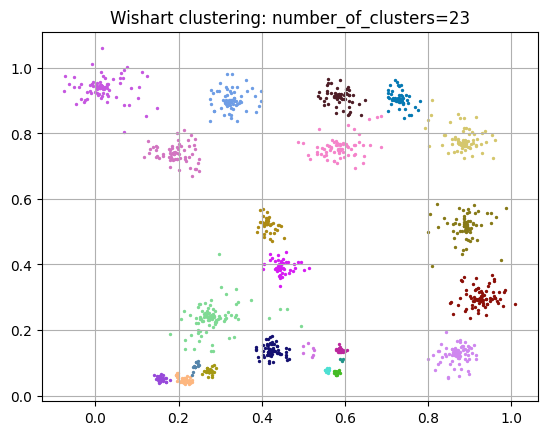

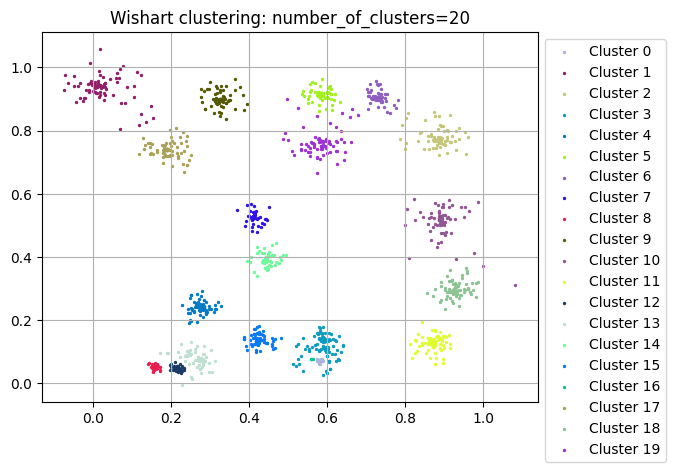

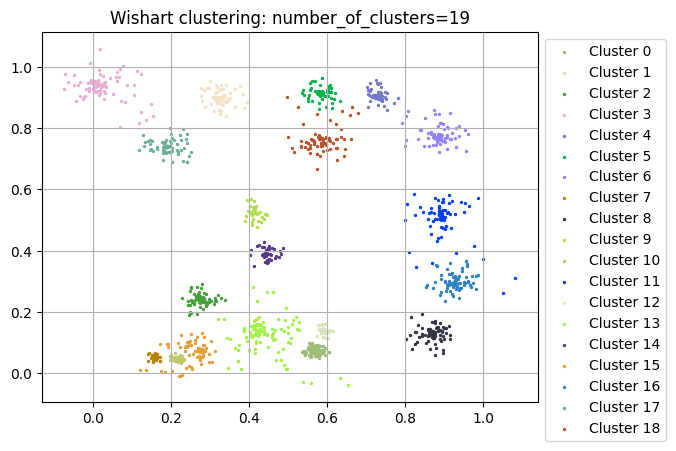

In [12]:
variants = [(10, 0.1), (20, 0.1), (30, 0.1)]
functions = [RMSSTD, RS, ModifiedHubert, CH, I, D, S]
results = [[0]]
for f in functions:
    results[-1].append(f(initial_clustering))
for r, mu in variants:
    results.append([])
    wishart_results = clasterify(K, data, r, mu, draw=True, draw_noise=False)
    results[-1].append(len(wishart_results[0]))
    wishart_results = wishart_results[1:]
    for f in functions:
        results[-1].append(f(wishart_results))

In [13]:
print("total number of points:", sum(len(clst) for clst in initial_clustering))
pd.DataFrame(results, columns=["noise points", "RMSSTD", "RS", "ModifiedHubert", "CH", "I", "D", "S"], index=["initial clustering"] + [f"clustering with r={r}, mu={mu}" for r, mu in variants])

total number of points: 1782


,noise points,RMSSTD,RS,ModifiedHubert,CH,I,D,S
initial clustering,0,0.034326,0.987494,0.369274,7322.405137,0.463057,0.000543,0.531919
"clustering with r=10, mu=0.1",399,0.026224,0.992896,0.378985,8640.072883,0.712772,0.025446,0.722824
"clustering with r=20, mu=0.1",373,0.026507,0.992732,0.379358,9985.963636,0.857290,0.027265,0.713669
"clustering with r=30, mu=0.1",325,0.029999,0.990733,0.380933,8541.204620,0.814101,0.032535,0.704119


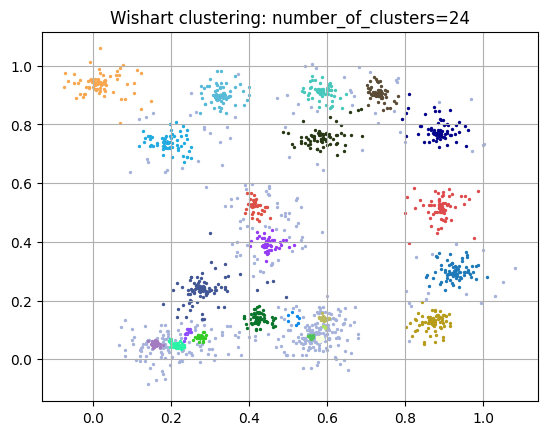

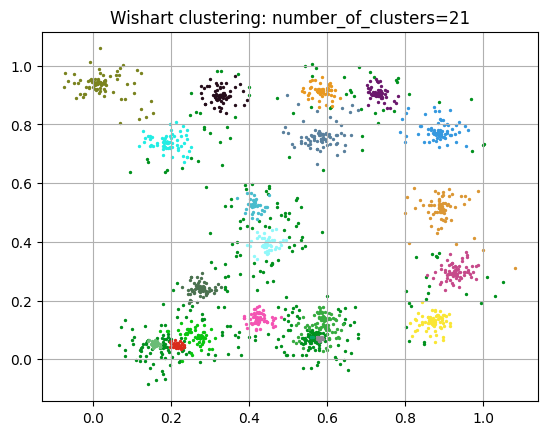

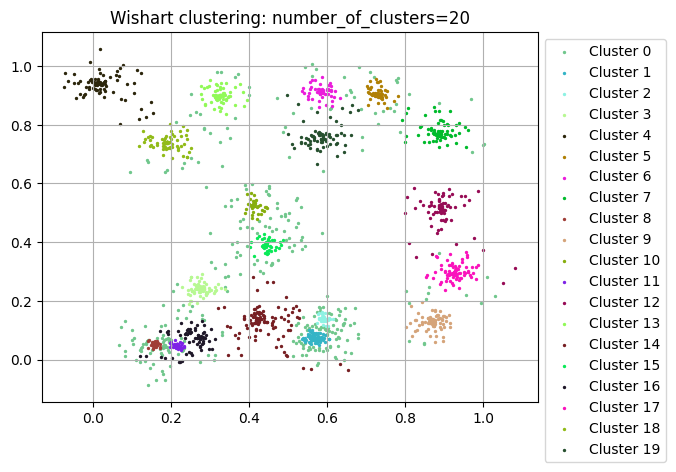

In [14]:
variants = [(10, 0.1), (20, 0.1), (30, 0.1)]
functions = [RMSSTD, RS, ModifiedHubert, CH, I, D, S]
results = [[0]]
for f in functions:
    results[-1].append(f(initial_clustering))
for r, mu in variants:
    results.append([])
    wishart_results = clasterify(K, data, r, mu, draw=True, draw_noise=True)
    results[-1].append(len(wishart_results[0]))
    #wishart_results = wishart_results[1:]
    for f in functions:
        results[-1].append(f(wishart_results))

In [17]:
print("total number of points:", sum(len(clst) for clst in initial_clustering))
pd.DataFrame(results, columns=["noise points", "RMSSTD", "RS", "ModifiedHubert", "CH", "I", "D", "S"], index=["initial clustering"] + [f"clustering with r={r}, mu={mu}" for r, mu in variants])

total number of points: 1782


,noise points,RMSSTD,RS,ModifiedHubert,CH,I,D,S
initial clustering,0,0.034326,0.987494,0.369274,7322.405137,0.463057,0.000543,0.531919
"clustering with r=10, mu=0.1",399,0.119262,0.849370,0.328246,430.998714,0.051553,0.001455,0.656920
"clustering with r=20, mu=0.1",373,0.120351,0.846345,0.327474,484.988170,0.066591,0.001240,0.639457
"clustering with r=30, mu=0.1",325,0.118123,0.851898,0.329291,533.431803,0.077729,0.001391,0.626489


In [16]:
print(f"RMSSTD: {RMSSTD(K, initial_clustering)}")
print(f"RMSSTD: {RMSSTD(K, wishart_results)}")

print(f"RS: {RS(initial_clustering)}")
print(f"RS: {RS(wishart_results)}")

print(f"ModifiedHubert: {ModifiedHubert(initial_clustering)}")
print(f"ModifiedHubert: {ModifiedHubert(wishart_results)}")

print(f"CH: {CH(initial_clustering)}")
print(f"CH: {CH(wishart_results)}")

print(f"I: {I(K, initial_clustering)}")
print(f"I: {I(K, wishart_results)}")

print(f"D: {D(initial_clustering)}")
print(f"D: {D(wishart_results)}")

print(f"S: {S(initial_clustering)}")
print(f"S: {S(wishart_results)}")

TypeError: RMSSTD() takes 1 positional argument but 2 were given

In [ ]:
numer = 0
denom = 0
all_center = np.average(flatten(initial_clustering), axis=0)
for i, clst in enumerate(initial_clustering):
    center = np.average(clst, axis=0)
    cursum = 0
    for xi, x in enumerate(clst):
        a = 0
        for yi, y in enumerate(clst):
            if xi != yi:
                a += np.linalg.norm(x - y)
        a /= (len(clst) - 1)
        b = 1e18
        for j, clst2 in enumerate(initial_clustering):
            if i != j:
                av_dist = 0
                for y in clst2:
                    av_dist += np.linalg.norm(x - y)
                av_dist /= len(clst2)
                b = min(b, av_dist)
        cursum += (b - a) / max(b, a)

    cursum /= len(clst)
    numer += cursum

print('---', numer / len(initial_clustering), '---')